# **Практика 7: Создание и использование генеративных противоречивых примеров (`GAN based Adversarial Examples`)**

По предмету: **Анализ защищенности систем искусственного интеллекта**

Выполнил студент **2 курса** группы **ББМО-02-23**

**Панков Евгений Ромуальдович**

##**Цель задания:**
Изучить использование генеративных моделей (`GAN — Generative Adversarial Networks`) для создания противоречивых примеров. В этом задании мы создадим противоречивые примеры с использованием `GAN` и проверим их влияние на модели классификации.

##**Задачи:**
1. Изучить концепцию генеративных противоречивых примеров.
2. Реализовать простую `GAN` для создания противоречивых изображений.
3. Оценить точность моделей классификации на противоречивых примерах, созданных с помощью `GAN`.
4. Сравнить атаку на обе модели (полносвязную и свёрточную сети).

##**Шаги выполнения:**

###**Шаг 1: Концепция генеративных противоречивых примеров**

 Генеративные противоречивые примеры — это изображения, созданные генеративными моделями, которые могут обманывать модели классификации. В отличие от стандартных атак (например, `FGSM` или `PGD`), где добавляются малые шумы, `GAN` могут генерировать реалистичные, но сложные для распознавания модели изображения, которые сложно отличить от настоящих данных.

###**Шаг 2: Создание простой `GAN` для генерации противоречивых примеров**

**Загружаем нужные для работы библиотеки:**

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K

**Загружаем данные `MNIST`:**

In [2]:
# Загрузка данных MNIST:
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images / 255.0

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


**Добавляем измерение для `CNN`:**

In [3]:
# Добавление одного измерения (для работы CNN):
train_images = np.expand_dims(train_images, axis=-1)

**Создадим генеративную состязательную сеть (`GAN`), состоящую из двух частей: генератора и дискриминатора. Генератор будет создавать изображения, а дискриминатор — пытаться распознать поддельные изображения.**

In [4]:
# Генератор:
def build_generator():
  model = tf.keras.Sequential()
  model.add(layers.Dense(128, activation='relu', input_dim=100))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())
  model.add(layers.Dense(784, activation='tanh'))
  model.add(layers.Reshape((28, 28, 1)))
  return model

# Дискриминатор:
def build_discriminator():
  model = tf.keras.Sequential()
  model.add(layers.Conv2D(64, (3, 3), padding='same', input_shape=(28, 28, 1)))
  model.add(layers.LeakyReLU())
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(1, activation='sigmoid'))
  return model

# Создание моделей:
generator = build_generator()
discriminator = build_discriminator()

# Компиляция дискриминатора:
discriminator.compile(optimizer='adam', loss='binary_crossentropy',
metrics=['accuracy'])

# Создание GAN:
gan_input = layers.Input(shape=(100,))
generated_image = generator(gan_input)
discriminator.trainable = False
validity = discriminator(generated_image)
gan = tf.keras.Model(gan_input, validity)
gan.compile(optimizer='adam', loss='binary_crossentropy')

# Функция обучения GAN:
def train_gan(generator, discriminator, gan, epochs=1000, batch_size=64):
  half_batch = batch_size // 2
  for epoch in range(epochs):
  # Обучение дискриминатора:
      idx = np.random.randint(0, train_images.shape[0], half_batch)
      real_images = train_images[idx]
      noise = np.random.normal(0, 1, (half_batch, 100))
      fake_images = generator.predict(noise)
      real_labels = np.ones((half_batch, 1))
      fake_labels = np.zeros((half_batch, 1))
      d_loss_real = discriminator.train_on_batch(real_images, real_labels)
      d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
  # Обучение генератора через дискриминатор:
      noise = np.random.normal(0, 1, (batch_size, 100))
      valid_labels = np.ones((batch_size, 1))
      g_loss = gan.train_on_batch(noise, valid_labels)
      if epoch % 100 == 0:
        print(f'{epoch} [D loss: {0.5 * np.add(d_loss_real, d_loss_fake)}] [G loss: {g_loss}]')
      K.clear_session()
# Обучение GAN:
train_gan(generator, discriminator, gan)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


0 [D loss: [0.71433294 0.3125    ]] [G loss: [array(0.69897246, dtype=float32), array(0.69897246, dtype=float32), array(0.5, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━

###**Шаг 3: Генерация противоречивых примеров с помощью GAN**

**Теперь мы сгенерируем противоречивые примеры, используя обученный генератор `GAN`:**

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


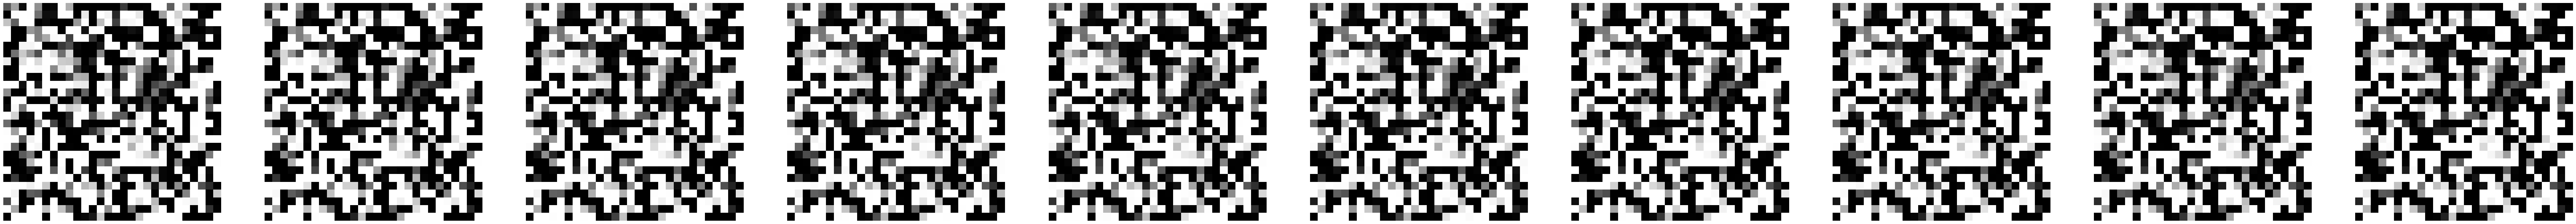

In [5]:
# Генерация противоречивых примеров:
def generate_adversarial_examples(generator, n_samples):
  noise = np.random.normal(0, 1, (n_samples, 100))
  generated_images = generator.predict(noise)
  return generated_images
# Генерация 100 примеров:
adversarial_images = generate_adversarial_examples(generator, 100)
# Визуализация противоречивых примеров:
plt.figure(figsize=(100, 100))
for i in range(10):
  plt.subplot(1, 10, i+1)
  plt.imshow(adversarial_images[i].reshape(28, 28), cmap='gray')
  plt.axis('off')
plt.show()

###**Шаг 4: Оценка моделей на противоречивых примерах**

 Теперь проверим, как обученные модели (полносвязная сеть и `CNN`) справляются с
 противоречивыми примерами, созданными с помощью `GAN`.

In [7]:
# Загрузка обученных моделей:
model1 = tf.keras.models.load_model('mnist_model_fully_connected.h5')
model2 = tf.keras.models.load_model('mnist_model_сonvolutional.h5')
# Оценка первой модели на противоречивых примерах:
adv_images_reshaped = adversarial_images.reshape(-1, 28, 28, 1)
loss1, acc1 = model1.evaluate(adv_images_reshaped, np.ones((100, 10)))
print(f'Accuracy of mnist_model_fully_connected on adversarial GAN examples: {acc1}')
# Оценка второй модели на противоречивых примерах:
loss2, acc2 = model2.evaluate(adv_images_reshaped, np.ones((100, 10)))
print(f'Accuracy of mnist_model_сonvolutional on adversarial GAN examples: {acc2}')

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - loss: 161.7660  
Accuracy of mnist_model_fully_connected on adversarial GAN examples: 0.0
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0000e+00 - loss: 851.9064 
Accuracy of mnist_model_сonvolutional on adversarial GAN examples: 0.0


###**Шаг 5: Вывод**

Оба классификатора показали нулевую точность при тестировании на противоречивых примерах, что свидетельствует о их полной уязвимости к атакам, использующим генеративные состязательные сети (`GAN`). Сгенерированные данные оказались достаточно реалистичными и сложными для корректного распознавания, что подтверждает высокую эффективность `GAN` в создании таких примеров. Для повышения устойчивости моделей к подобным атакам необходимо внедрить защитные методы, включая обучение с использованием противоречивых примеров (`Adversarial Training`), а также применять методы регуляризации и оптимизацию архитектуры.